In [ ]:
# This file aggregates all steps for running analysis on predictions.

# Step 1 - Run this each time once for aerial and once for multi-perspective by changing the file name
#!/usr/bin/env python3
"""
Script to add true_label column to prediction CSV based on image filename.
- Renames 'true_label' (CropModel prediction) to 'predicted_label'
- Adds new 'true_label' column derived from image_path filename

Usage:
  python add_true_label.py <input_csv> <output_csv>

Examples:
  python add_true_label.py "pred_output_tiles_multiperspective.csv" "pred_output_tiles_multiperspective_with_true_label.csv"
  python add_true_label.py "pred_output_tiles_aerial.csv" "pred_output_tiles_aerial_with_true_label.csv"
"""

import csv
import os
import sys

def get_true_label_from_filename(image_path):
  """Extract the true label from the image filename."""
  name = image_path.lower()
  if name.startswith('jute'):
      return 'jute'
  elif name.startswith('maize') or 'corn' in name:
      return 'maize'
  elif name.startswith('rice'):
      return 'rice'
  elif name.startswith('sugarcane'):
      return 'sugarcane'
  elif name.startswith('wheat'):
      return 'wheat'
  else:
      return 'unknown'

def process_csv(input_file, output_file):
  """Process the CSV file and add true_label column."""

  with open(input_file, 'r', newline='', encoding='utf-8') as infile:
      reader = csv.DictReader(infile)

      # Get original fieldnames and modify
      original_fields = reader.fieldnames

      # Create new fieldnames:
      # - Rename 'true_label' to 'predicted_label'
      # - Add 'true_label' at the end
      new_fields = []
      for field in original_fields:
          if field == 'true_label':
              new_fields.append('predicted_label')
          else:
              new_fields.append(field)
      new_fields.append('true_label')

      # Read all rows
      rows = list(reader)

  # Ensure output directory exists
  output_dir = os.path.dirname(output_file)
  if output_dir and not os.path.exists(output_dir):
      os.makedirs(output_dir)
      print(f"Created directory: {output_dir}")

  # Write output file
  with open(output_file, 'w', newline='', encoding='utf-8') as outfile:
      writer = csv.DictWriter(outfile, fieldnames=new_fields)
      writer.writeheader()

      for row in rows:
          # Create new row with renamed field and added true_label
          new_row = {}
          for field in original_fields:
              if field == 'true_label':
                  new_row['predicted_label'] = row[field]
              else:
                  new_row[field] = row[field]

          # Add true_label based on image_path
          new_row['true_label'] = get_true_label_from_filename(row['image_path'])

          writer.writerow(new_row)

  print(f"Processed {len(rows)} rows")
  print(f"Input:  {input_file}")
  print(f"Output: {output_file}")

if __name__ == "__main__":
      # For Colab - files in /content directory
      input_file = "/content/pred_output_tiles_aerial.csv"  # Change filename as needed
      output_file = "/content/pred_output_tiles_aerial_with_true_label.csv"
      #input_file = "/content/pred_output_tiles_multiperspective.csv"  # Change filename as needed
      #output_file = "/content/pred_output_tiles_multiperspective_with_true_label.csv"

      process_csv(input_file, output_file)
      print("\nDone!")


Processed 4713 rows
Input:  /content/pred_output_tiles_aerial.csv
Output: /content/pred_output_tiles_aerial_with_true_label.csv

Done!


Total number of predictions before filtering: 4713
  Predictions after filtering by score (>= 0.0): 4713
  Predictions after filtering by size (W:>80, H:>80, A:>6400): 1016

Accuracy by Crop Model Score Bucket :
| score_bucket   |   Incorrect Predictions |   Correct Predictions |   Total Predictions |   Percent Correct |
|:---------------|------------------------:|----------------------:|--------------------:|------------------:|
| 0.0-0.1        |                    0.00 |                  0.00 |                0.00 |            nan    |
| 0.1-0.2        |                    0.00 |                  0.00 |                0.00 |            nan    |
| 0.2-0.3        |                   74.00 |                 27.00 |              101.00 |             26.73 |
| 0.3-0.4        |                  129.00 |                 48.00 |              177.00 |             27.12 |
| 0.4-0.5        |                  144.00 |                 57.00 |              201.00 |             28.36 |
| 0.5-0.6  

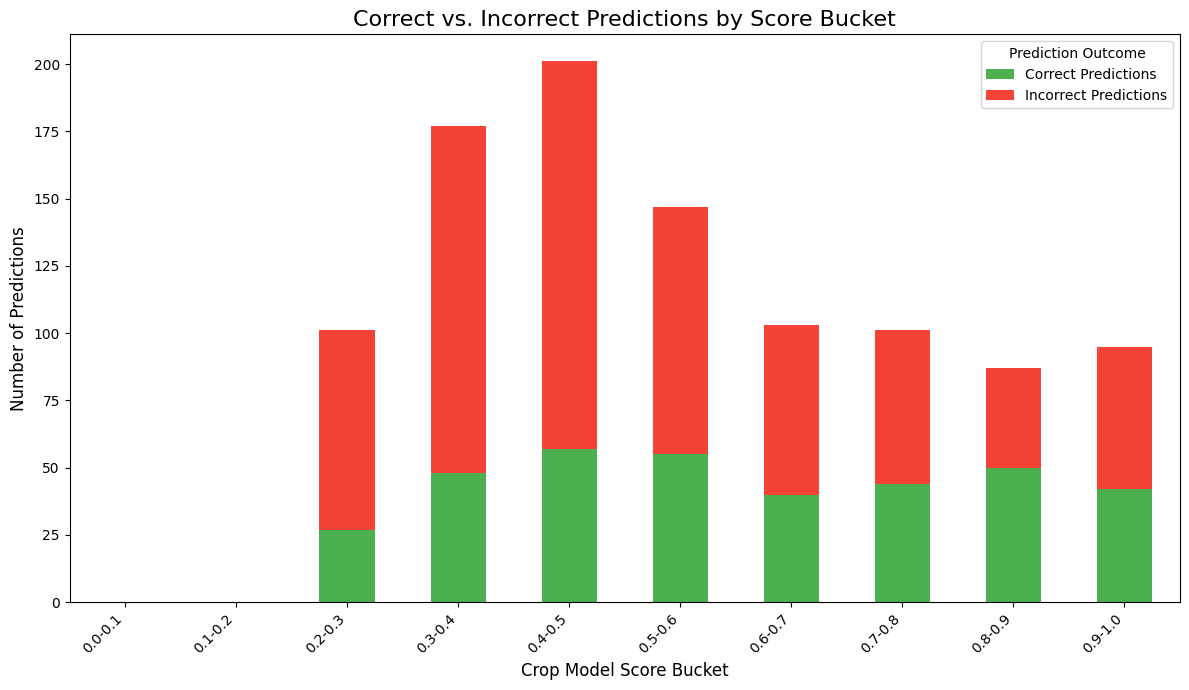

In [ ]:
# STEP 2: Aerial correct vs. incorrect graphs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def analyze_prediction_accuracy_with_filters(file_path):
    """
    Reads a CSV file, filters predictions based on score and box size,
    then analyzes the accuracy of the remaining predictions within
    different cropmodel_score buckets and visualizes the results.

    Args:
        file_path (str): The path to the CSV file. The file must contain
                         'predicted_label', 'true_label', and 'cropmodel_score' columns,
                         as well as 'xmin', 'ymin', 'xmax', and 'ymax' for box dimensions.
    """
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' was not found.")
        print("CSV file needs to be uploaded to the Colab environment or the correct path needs to be provided.")
        return

    try:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)

        # Check for all required columns
        required_columns = ['predicted_label', 'true_label', 'cropmodel_score', 'xmin', 'ymin', 'xmax', 'ymax']
        if not all(col in df.columns for col in required_columns):
            missing_cols = [col for col in required_columns if col not in df.columns]
            print(f"Error: The following required column(s) were not found in '{file_path}': {', '.join(missing_cols)}")
            print("CSV file should contain these columns, such as 'pred_output_tiles_multiperspective_with_true_label.csv'.")
            return

        initial_row_count = len(df)
        print(f"Total number of predictions before filtering: {initial_row_count}")

        # --- Define and apply filters ---
        # Adjust these values to suit specific analysis needs.
        MIN_CROPMODEL_SCORE = 0.0
        MIN_BOX_WIDTH = 80
        MIN_BOX_HEIGHT = 80
        MIN_BOX_AREA = 6400  # Example: 80 * 80

        # Filter by minimum cropmodel_score
        df = df[df['cropmodel_score'] >= MIN_CROPMODEL_SCORE]
        filtered_by_score_count = len(df)
        print(f"  Predictions after filtering by score (>= {MIN_CROPMODEL_SCORE}): {filtered_by_score_count}")

        # Calculate box dimensions for filtering
        df['box_width'] = df['xmax'] - df['xmin']
        df['box_height'] = df['ymax'] - df['ymin']
        df['box_area'] = df['box_width'] * df['box_height']

        # Filter by minimum box dimensions
        df = df[df['box_width'] >= MIN_BOX_WIDTH]
        df = df[df['box_height'] >= MIN_BOX_HEIGHT]
        df = df[df['box_area'] >= MIN_BOX_AREA]

        filtered_by_size_count = len(df)
        print(f"  Predictions after filtering by size (W:>{MIN_BOX_WIDTH}, H:>{MIN_BOX_HEIGHT}, A:>{MIN_BOX_AREA}): {filtered_by_size_count}")

        if df.empty:
            print("\nNo predictions matched the filter criteria. Adjust filter values and try again.")
            return

        # --- Analysis on the filtered data ---

        # Create a new column 'is_correct'
        df['is_correct'] = (df['predicted_label'] == df['true_label'])

        # Define score bins and labels for the buckets
        bins = np.arange(0, 1.1, 0.1)
        labels = [f'{b:.1f}-{b+0.1:.1f}' for b in bins[:-1]]

        # Create a new column 'score_bucket' by binning the scores
        df['score_bucket'] = pd.cut(df['cropmodel_score'], bins=bins, labels=labels, right=False)

        # Group by score bucket and calculate correct/incorrect counts
        accuracy_by_bucket = df.groupby('score_bucket')['is_correct'].value_counts().unstack(fill_value=0)

        # Ensure both True (correct) and False (incorrect) columns exist
        if True not in accuracy_by_bucket.columns:
            accuracy_by_bucket[True] = 0
        if False not in accuracy_by_bucket.columns:
            accuracy_by_bucket[False] = 0

        # Rename columns for clarity
        accuracy_by_bucket = accuracy_by_bucket.rename(columns={True: 'Correct Predictions', False: 'Incorrect Predictions'})

        # Calculate and add the percent correct column
        accuracy_by_bucket['Total Predictions'] = accuracy_by_bucket['Correct Predictions'] + accuracy_by_bucket['Incorrect Predictions']
        accuracy_by_bucket['Percent Correct'] = (accuracy_by_bucket['Correct Predictions'] / accuracy_by_bucket['Total Predictions']) * 100

        # Print a summary table
        print("\nAccuracy by Crop Model Score Bucket :")
        print(accuracy_by_bucket.to_markdown(floatfmt=".2f"))
        print("\n")

        # Create the bar chart
        accuracy_by_bucket[['Correct Predictions', 'Incorrect Predictions']].plot(kind='bar', figsize=(12, 7), stacked=True, color=['#4CAF50', '#F44336'])
        plt.title('Correct vs. Incorrect Predictions by Score Bucket', fontsize=16)
        plt.xlabel('Crop Model Score Bucket', fontsize=12)
        plt.ylabel('Number of Predictions', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Prediction Outcome')
        plt.tight_layout()
        plt.show()

    except pd.errors.EmptyDataError:
        print(f"Error: The file '{file_path}' is empty.")
    except pd.errors.ParserError:
        print(f"Error: Could not parse '{file_path}'. Please check if it's a valid CSV file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    # --- Instructions for use in Colab ---
    # 1. Upload one of the CSV files with true labels to Colab environment.
    #    For example: 'pred_output_tiles_multiperspective_with_true_label.csv'
    # 2. Adjust the file_path and filter constants (MIN_CROPMODEL_SCORE, MIN_BOX_WIDTH, etc.) below.
    # 3. Run this script.

    #file_path = "pred_output_tiles_multiperspective_with_true_label.csv"
    file_path = "pred_output_tiles_aerial_with_true_label.csv"

    analyze_prediction_accuracy_with_filters(file_path)


Total number of predictions before filtering: 5006
  Predictions after filtering by score (>= 0.0): 4980
  Predictions after filtering by size (W:>80, H:>80, A:>6400): 665

Accuracy by Crop Model Score Bucket :
| score_bucket   |   Incorrect Predictions |   Correct Predictions |   Total Predictions |   Percent Correct |
|:---------------|------------------------:|----------------------:|--------------------:|------------------:|
| 0.0-0.1        |                    0.00 |                  0.00 |                0.00 |            nan    |
| 0.1-0.2        |                    0.00 |                  0.00 |                0.00 |            nan    |
| 0.2-0.3        |                   28.00 |                  7.00 |               35.00 |             20.00 |
| 0.3-0.4        |                   22.00 |                 13.00 |               35.00 |             37.14 |
| 0.4-0.5        |                   42.00 |                 14.00 |               56.00 |             25.00 |
| 0.5-0.6   

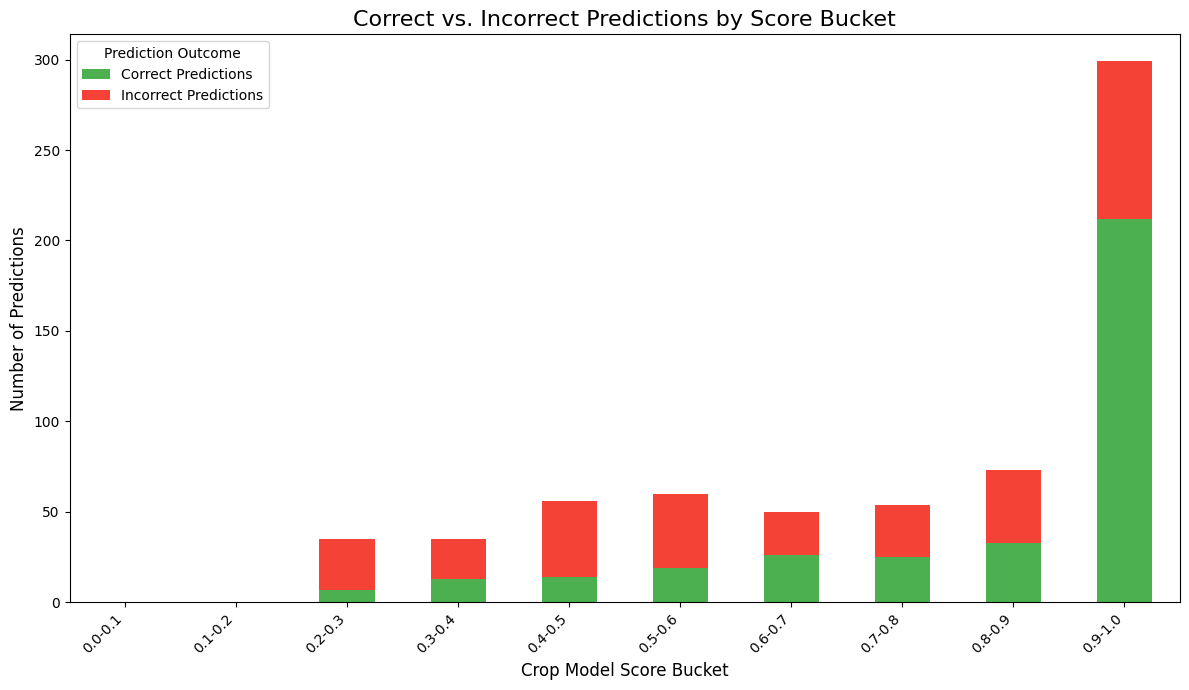

In [ ]:
# STEP 3: Multi-perspective correct vs. incorrect graphs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def analyze_prediction_accuracy_with_filters(file_path):
    """
    Reads a CSV file, filters predictions based on score and box size,
    then analyzes the accuracy of the remaining predictions within
    different cropmodel_score buckets and visualizes the results.

    Args:
        file_path (str): The path to the CSV file. The file must contain
                         'predicted_label', 'true_label', and 'cropmodel_score' columns,
                         as well as 'xmin', 'ymin', 'xmax', and 'ymax' for box dimensions.
    """
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' was not found.")
        print("CSV file needs to be uploaded to the Colab environment or the correct path needs to be provided.")
        return

    try:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)

        # Check for all required columns
        required_columns = ['predicted_label', 'true_label', 'cropmodel_score', 'xmin', 'ymin', 'xmax', 'ymax']
        if not all(col in df.columns for col in required_columns):
            missing_cols = [col for col in required_columns if col not in df.columns]
            print(f"Error: The following required column(s) were not found in '{file_path}': {', '.join(missing_cols)}")
            print("CSV file should contain these columns, such as 'pred_output_tiles_multiperspective_with_true_label.csv'.")
            return

        initial_row_count = len(df)
        print(f"Total number of predictions before filtering: {initial_row_count}")

        # --- Define and apply filters ---
        # Adjust these values to suit specific analysis needs.
        MIN_CROPMODEL_SCORE = 0.0
        MIN_BOX_WIDTH = 80
        MIN_BOX_HEIGHT = 80
        MIN_BOX_AREA = 6400  # Example: 80 * 80

        # Filter by minimum cropmodel_score
        df = df[df['cropmodel_score'] >= MIN_CROPMODEL_SCORE]
        filtered_by_score_count = len(df)
        print(f"  Predictions after filtering by score (>= {MIN_CROPMODEL_SCORE}): {filtered_by_score_count}")

        # Calculate box dimensions for filtering
        df['box_width'] = df['xmax'] - df['xmin']
        df['box_height'] = df['ymax'] - df['ymin']
        df['box_area'] = df['box_width'] * df['box_height']

        # Filter by minimum box dimensions
        df = df[df['box_width'] >= MIN_BOX_WIDTH]
        df = df[df['box_height'] >= MIN_BOX_HEIGHT]
        df = df[df['box_area'] >= MIN_BOX_AREA]

        filtered_by_size_count = len(df)
        print(f"  Predictions after filtering by size (W:>{MIN_BOX_WIDTH}, H:>{MIN_BOX_HEIGHT}, A:>{MIN_BOX_AREA}): {filtered_by_size_count}")

        if df.empty:
            print("\nNo predictions matched the filter criteria. Adjust filter values and try again.")
            return

        # --- Analysis on the filtered data ---

        # Create a new column 'is_correct'
        df['is_correct'] = (df['predicted_label'] == df['true_label'])

        # Define score bins and labels for the buckets
        bins = np.arange(0, 1.1, 0.1)
        labels = [f'{b:.1f}-{b+0.1:.1f}' for b in bins[:-1]]

        # Create a new column 'score_bucket' by binning the scores
        df['score_bucket'] = pd.cut(df['cropmodel_score'], bins=bins, labels=labels, right=False)

        # Group by score bucket and calculate correct/incorrect counts
        accuracy_by_bucket = df.groupby('score_bucket')['is_correct'].value_counts().unstack(fill_value=0)

        # Ensure both True (correct) and False (incorrect) columns exist
        if True not in accuracy_by_bucket.columns:
            accuracy_by_bucket[True] = 0
        if False not in accuracy_by_bucket.columns:
            accuracy_by_bucket[False] = 0

        # Rename columns for clarity
        accuracy_by_bucket = accuracy_by_bucket.rename(columns={True: 'Correct Predictions', False: 'Incorrect Predictions'})

        # Calculate and add the percent correct column
        accuracy_by_bucket['Total Predictions'] = accuracy_by_bucket['Correct Predictions'] + accuracy_by_bucket['Incorrect Predictions']
        accuracy_by_bucket['Percent Correct'] = (accuracy_by_bucket['Correct Predictions'] / accuracy_by_bucket['Total Predictions']) * 100

        # Print a summary table
        print("\nAccuracy by Crop Model Score Bucket :")
        print(accuracy_by_bucket.to_markdown(floatfmt=".2f"))
        print("\n")

        # Create the bar chart
        accuracy_by_bucket[['Correct Predictions', 'Incorrect Predictions']].plot(kind='bar', figsize=(12, 7), stacked=True, color=['#4CAF50', '#F44336'])
        plt.title('Correct vs. Incorrect Predictions by Score Bucket', fontsize=16)
        plt.xlabel('Crop Model Score Bucket', fontsize=12)
        plt.ylabel('Number of Predictions', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Prediction Outcome')
        plt.tight_layout()
        plt.show()

    except pd.errors.EmptyDataError:
        print(f"Error: The file '{file_path}' is empty.")
    except pd.errors.ParserError:
        print(f"Error: Could not parse '{file_path}'. Please check if it's a valid CSV file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    # --- Instructions for use in Colab ---
    # 1. Upload one of the CSV files with true labels to Colab environment.
    #    For example: 'pred_output_tiles_multiperspective_with_true_label.csv'
    # 2. Adjust the file_path and filter constants (MIN_CROPMODEL_SCORE, MIN_BOX_WIDTH, etc.) below.
    # 3. Run this script.

    file_path = "pred_output_tiles_multiperspective_with_true_label.csv"
    #file_path = "pred_output_tiles_aerial_with_true_label.csv"

    analyze_prediction_accuracy_with_filters(file_path)


Total predictions (5 crop classes): 5006
Crop classes: jute (0), maize (1), rice (2), sugarcane (3), wheat (4)

Applying 80x80 Minimum Box Size:
  Score >= 0.0
  Box size >= 80x80 (area >= 6400)
Predictions after filtering: 665
Overall accuracy: 52.93%

ACCURACY BY SCORE BUCKET (Overall)
is_correct    Incorrect_Predictions  Correct_Predictions  Total_Predictions  \
score_bucket                                                                  
0.2-0.3                          28                    7                 35   
0.3-0.4                          22                   13                 35   
0.4-0.5                          42                   14                 56   
0.5-0.6                          41                   19                 60   
0.6-0.7                          24                   26                 50   
0.7-0.8                          29                   25                 54   
0.8-0.9                          40                   33                 73   


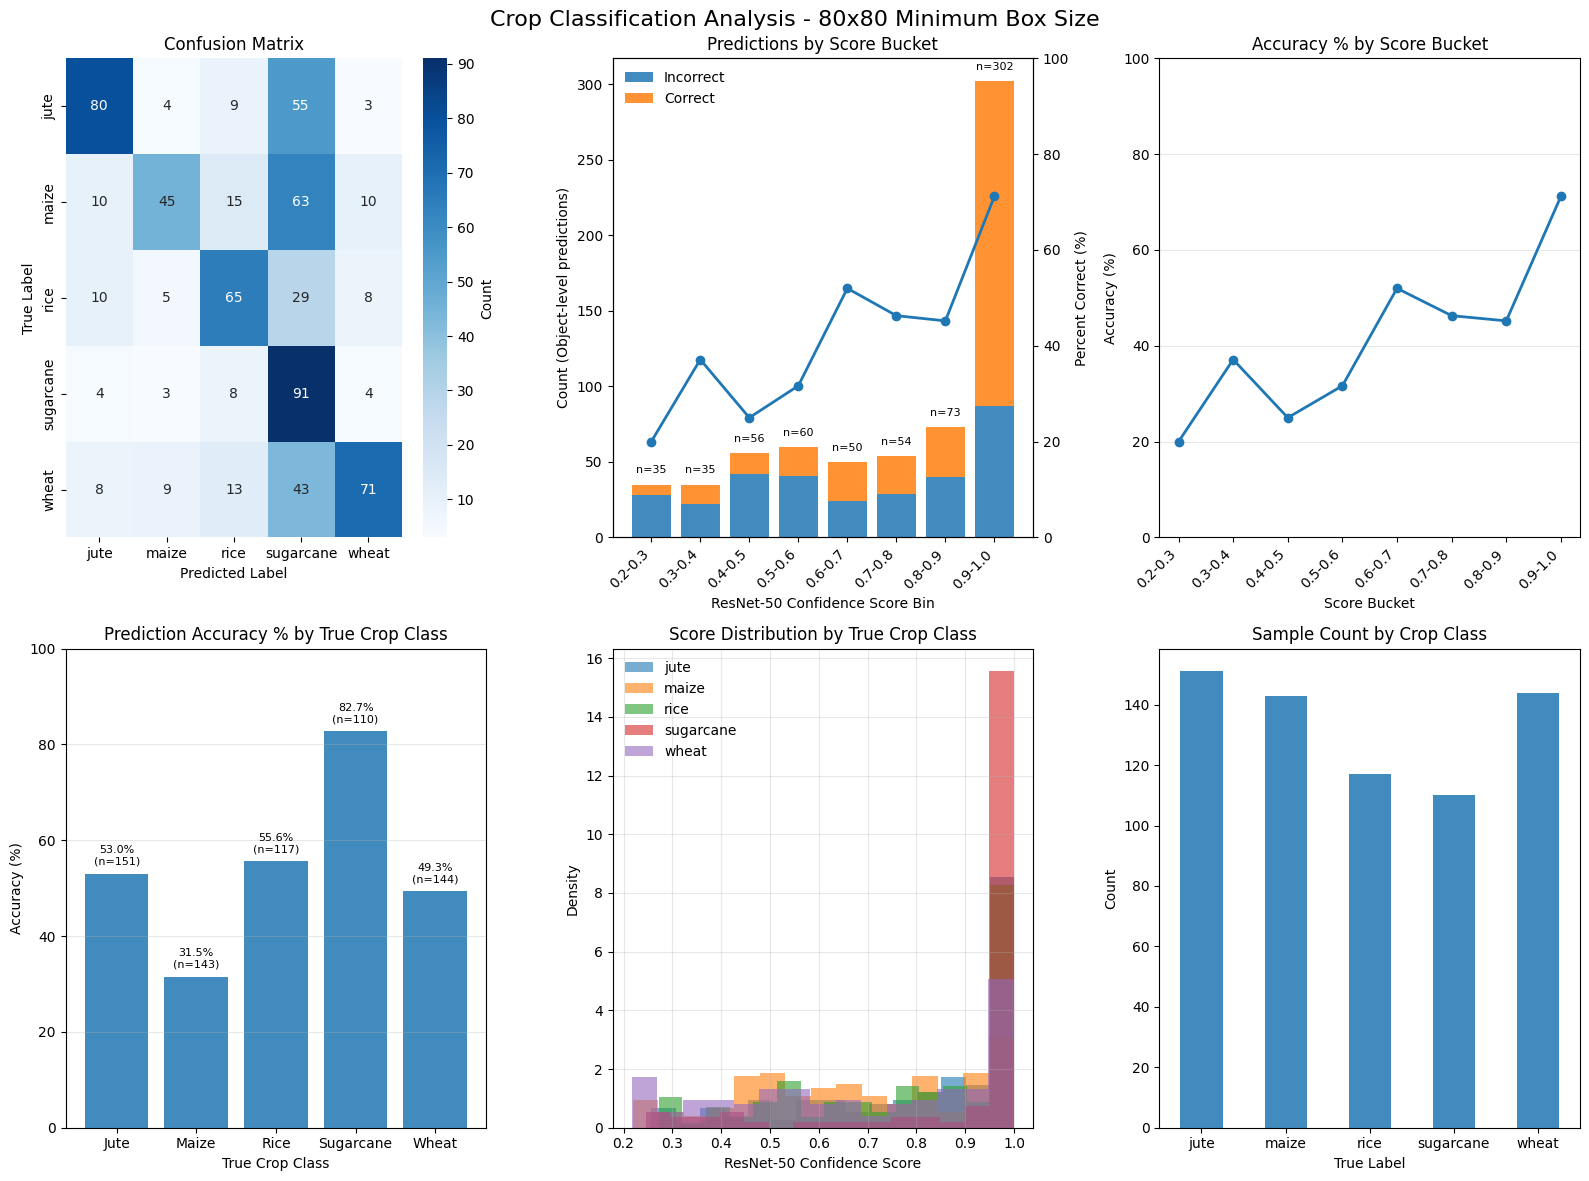


DETAILED MISCLASSIFICATION ANALYSIS

JUTE:
  Total: 151, Correct: 80, Accuracy: 53.0%
  Misclassified as:
    → sugarcane: 55 times (36.4%)
    → rice: 9 times (6.0%)
    → maize: 4 times (2.6%)
    → wheat: 3 times (2.0%)

MAIZE:
  Total: 143, Correct: 45, Accuracy: 31.5%
  Misclassified as:
    → sugarcane: 63 times (44.1%)
    → rice: 15 times (10.5%)
    → jute: 10 times (7.0%)
    → wheat: 10 times (7.0%)

RICE:
  Total: 117, Correct: 65, Accuracy: 55.6%
  Misclassified as:
    → sugarcane: 29 times (24.8%)
    → jute: 10 times (8.5%)
    → wheat: 8 times (6.8%)
    → maize: 5 times (4.3%)

SUGARCANE:
  Total: 110, Correct: 91, Accuracy: 82.7%
  Misclassified as:
    → rice: 8 times (7.3%)
    → wheat: 4 times (3.6%)
    → jute: 4 times (3.6%)
    → maize: 3 times (2.7%)

WHEAT:
  Total: 144, Correct: 71, Accuracy: 49.3%
  Misclassified as:
    → sugarcane: 43 times (29.9%)
    → rice: 13 times (9.0%)
    → maize: 9 times (6.2%)
    → jute: 8 times (5.6%)

VERIFICATION: High-conf

In [ ]:
# STEP 4: CLASSIFICATION ACCURACY ANALYSIS FOR ***MULTI-PERSPECTIVE*** PREDICTIONS

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def analyze_crop_classification_performance(file_path, use_strict_size_filters=True):
    """
    Analyzes crop classification performance with comprehensive metrics and visualizations.

    Args:
        file_path (str): Path to the CSV file with predictions
        use_strict_size_filters (bool): If True, uses stricter filters (80x80 boxes, score>=0.0)
                               If False, uses lenient filters (20x20 boxes, score>=0.0)
    """
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' was not found.")
        return

    try:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Check required columns
        required_columns = ['predicted_label', 'true_label', 'cropmodel_score', 'xmin', 'ymin', 'xmax', 'ymax']
        if not all(col in df.columns for col in required_columns):
            missing_cols = [col for col in required_columns if col not in df.columns]
            print(f"Error: Missing columns: {', '.join(missing_cols)}")
            return

        # Remove unknown labels - focus on 5 crop classes
        valid_labels = ['jute', 'maize', 'rice', 'sugarcane', 'wheat']
        df = df[df['true_label'].isin(valid_labels)].copy()

        print(f"Total predictions (5 crop classes): {len(df)}")
        print("Crop classes: jute (0), maize (1), rice (2), sugarcane (3), wheat (4)")

        # Apply filters based on choice
        if use_strict_size_filters:
            # Old script filters (stricter)
            MIN_CROPMODEL_SCORE = 0.0
            MIN_BOX_WIDTH = 80
            MIN_BOX_HEIGHT = 80
            MIN_BOX_AREA = 6400
            filter_description = "80x80 Minimum Box Size"
        else:
            # New script filters (more lenient)
            MIN_CROPMODEL_SCORE = 0.0
            MIN_BOX_WIDTH = 20
            MIN_BOX_HEIGHT = 20
            MIN_BOX_AREA = 400
            filter_description = "20x20 Minimum Box Size"

        print(f"\nApplying {filter_description}:")
        print(f"  Score >= {MIN_CROPMODEL_SCORE}")
        print(f"  Box size >= {MIN_BOX_WIDTH}x{MIN_BOX_HEIGHT} (area >= {MIN_BOX_AREA})")

        # Calculate box dimensions
        df['box_width'] = df['xmax'] - df['xmin']
        df['box_height'] = df['ymax'] - df['ymin']
        df['box_area'] = df['box_width'] * df['box_height']

        # Apply filters
        df_filtered = df[
            (df['cropmodel_score'] >= MIN_CROPMODEL_SCORE) &
            (df['box_width'] >= MIN_BOX_WIDTH) &
            (df['box_height'] >= MIN_BOX_HEIGHT) &
            (df['box_area'] >= MIN_BOX_AREA)
        ].copy()

        print(f"Predictions after filtering: {len(df_filtered)}")

        if df_filtered.empty:
            print("No predictions match the filter criteria!")
            return

        # Calculate correctness
        df_filtered['is_correct'] = (df_filtered['predicted_label'] == df_filtered['true_label'])
        overall_accuracy = df_filtered['is_correct'].mean() * 100
        print(f"Overall accuracy: {overall_accuracy:.2f}%")

        # --- SCORE BUCKET ANALYSIS ---
        # IMPORTANT: drop empty 0.0–0.2 buckets since they are all zero in current outputs
        bins = np.arange(0.2, 1.01, 0.1)  # 0.2–1.0
        labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-1)]
        df_filtered['score_bucket'] = pd.cut(
            df_filtered['cropmodel_score'],
            bins=bins,
            labels=labels,
            right=False,
            include_lowest=True
        )

        # Build bucket table: counts of correct/incorrect + percent correct
        bucket_counts = (
            df_filtered.groupby(['score_bucket', 'is_correct'])
            .size()
            .unstack(fill_value=0)
            .rename(columns={False: 'Incorrect_Predictions', True: 'Correct_Predictions'})
        )

        # Ensure both columns exist even if one is missing
        for col in ['Correct_Predictions', 'Incorrect_Predictions']:
            if col not in bucket_counts.columns:
                bucket_counts[col] = 0

        bucket_counts['Total_Predictions'] = bucket_counts['Correct_Predictions'] + bucket_counts['Incorrect_Predictions']
        bucket_counts['Percent_Correct'] = np.where(
            bucket_counts['Total_Predictions'] > 0,
            100 * bucket_counts['Correct_Predictions'] / bucket_counts['Total_Predictions'],
            np.nan
        )

        print(f"\n{'='*60}")
        print("ACCURACY BY SCORE BUCKET (Overall)")
        print(f"{'='*60}")
        display_cols = ['Incorrect_Predictions', 'Correct_Predictions', 'Total_Predictions', 'Percent_Correct']
        print(bucket_counts[display_cols].round(2))

        # --- CLASS-SPECIFIC ANALYSIS ---
        print(f"\n{'='*60}")
        print("ACCURACY BY CROP CLASS")
        print(f"{'='*60}")
        print("Note: This shows how well each TRUE crop class was classified")
        print("(i.e., when the actual crop was X, how often was it correctly predicted as X)")

        class_accuracy = df_filtered.groupby('true_label')['is_correct'].agg(['count', 'sum', 'mean'])
        class_accuracy.columns = ['Total_Predictions', 'Correct_Predictions', 'Accuracy_Rate']
        class_accuracy['Incorrect_Predictions'] = class_accuracy['Total_Predictions'] - class_accuracy['Correct_Predictions']
        class_accuracy['Percent_Correct'] = (class_accuracy['Accuracy_Rate'] * 100).round(1)
        class_accuracy = class_accuracy[['Total_Predictions', 'Correct_Predictions', 'Incorrect_Predictions', 'Percent_Correct']]

        # Force a consistent class order for plotting + readability
        class_order = ['jute', 'maize', 'rice', 'sugarcane', 'wheat']
        class_accuracy = class_accuracy.reindex(class_order)

        print(class_accuracy)

        # --- CONFUSION MATRIX ---
        print(f"\n{'='*60}")
        print("CONFUSION MATRIX")
        print(f"{'='*60}")
        print("Rows = True Label, Columns = Predicted Label")
        confusion_matrix = pd.crosstab(df_filtered['true_label'], df_filtered['predicted_label'], margins=True)
        print(confusion_matrix)

        # --- VISUALIZATIONS ---
        # We’ll keep 2×3 layout, but make the two *submitted* plots clearer:
        # (2) Predictions by Score Bucket -> stacked counts + accuracy line + n labels
        # (4) Prediction Accuracy % by True Crop Class -> explicit labels + % + n
        plt.figure(figsize=(16, 12))

        # 1. Confusion Matrix Heatmap
        plt.subplot(2, 3, 1)
        confusion_no_margins = pd.crosstab(df_filtered['true_label'], df_filtered['predicted_label'])
        sns.heatmap(confusion_no_margins, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.title('Confusion Matrix', fontsize=12)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        # 2. UPDATED: Predictions by Score Bucket (STACKED) + Accuracy line (2nd axis) + n labels
        ax = plt.subplot(2, 3, 2)

        x = np.arange(len(bucket_counts.index))
        incorrect = bucket_counts['Incorrect_Predictions'].values
        correct = bucket_counts['Correct_Predictions'].values
        total = bucket_counts['Total_Predictions'].values
        pct = bucket_counts['Percent_Correct'].values

        # Stacked bars (counts)
        ax.bar(x, incorrect, label='Incorrect', alpha=0.85)
        ax.bar(x, correct, bottom=incorrect, label='Correct', alpha=0.85)

        ax.set_title('Predictions by Score Bucket', fontsize=12)
        ax.set_xlabel('ResNet-50 Confidence Score Bin')
        ax.set_ylabel('Count (Object-level predictions)')
        ax.set_xticks(x)
        ax.set_xticklabels(bucket_counts.index.astype(str), rotation=45, ha='right')

        # n labels on each bar
        y_max = max(total) if len(total) else 1
        for i, t in enumerate(total):
            ax.text(i, t + 0.02 * y_max, f"n={int(t)}", ha='center', va='bottom', fontsize=8)

        # Accuracy line on secondary axis
        ax2 = ax.twinx()
        ax2.plot(x, pct, marker='o', linewidth=2)
        ax2.set_ylabel('Percent Correct (%)')
        ax2.set_ylim(0, 100)

        # Legend (explicit)
        ax.legend(loc='upper left', frameon=False)

        # 3. (Optional) keep original accuracy-by-bucket plot OR repurpose it
        plt.subplot(2, 3, 3)
        plt.plot(bucket_counts.index.astype(str), bucket_counts['Percent_Correct'].values, marker='o', linewidth=2)
        plt.title('Accuracy % by Score Bucket', fontsize=12)
        plt.xlabel('Score Bucket')
        plt.ylabel('Accuracy (%)')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 100)
        plt.grid(axis='y', alpha=0.3)

        # 4. UPDATED: Prediction Accuracy % by True Crop Class (explicit labels + % + n)
        axc = plt.subplot(2, 3, 4)
        acc_vals = class_accuracy['Percent_Correct'].values
        axc.bar(np.arange(len(class_order)), acc_vals, alpha=0.85)
        axc.set_title('Prediction Accuracy % by True Crop Class', fontsize=12)
        axc.set_xlabel('True Crop Class')
        axc.set_ylabel('Accuracy (%)')
        axc.set_ylim(0, 100)
        axc.set_xticks(np.arange(len(class_order)))
        axc.set_xticklabels([c.capitalize() for c in class_order], rotation=0)
        axc.grid(axis='y', alpha=0.3)

        # Label each bar with % and n
        ns = class_accuracy['Total_Predictions'].values
        for i, (a, n_i) in enumerate(zip(acc_vals, ns)):
            if pd.notna(a):
                axc.text(i, a + 1.5, f"{a:.1f}%\n(n={int(n_i)})", ha='center', va='bottom', fontsize=8)

        # 5. Score Distribution by Crop Class (keep as-is, but ensure consistent order/colors)
        plt.subplot(2, 3, 5)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        for i, label in enumerate(class_order):
            label_scores = df_filtered[df_filtered['true_label'] == label]['cropmodel_score']
            if len(label_scores) > 0:
                plt.hist(label_scores, bins=15, alpha=0.6, label=f'{label}',
                         color=colors[i], density=True)
        plt.xlabel('ResNet-50 Confidence Score')
        plt.ylabel('Density')
        plt.title('Score Distribution by True Crop Class')
        plt.legend(frameon=False)
        plt.grid(alpha=0.3)

        # 6. Sample Count by Class (explicit order)
        plt.subplot(2, 3, 6)
        class_counts = df_filtered['true_label'].value_counts().reindex(class_order)
        class_counts.plot(kind='bar', alpha=0.85)
        plt.title('Sample Count by Crop Class', fontsize=12)
        plt.xlabel('True Label')
        plt.ylabel('Count')
        plt.xticks(rotation=0)

        plt.suptitle(f'Crop Classification Analysis - {filter_description}', fontsize=16)
        plt.tight_layout()
        plt.show()

        # --- DETAILED CLASS PERFORMANCE ---
        print(f"\n{'='*60}")
        print("DETAILED MISCLASSIFICATION ANALYSIS")
        print(f"{'='*60}")

        for label in class_order:
            label_df = df_filtered[df_filtered['true_label'] == label]
            if not label_df.empty:
                accuracy = label_df['is_correct'].mean() * 100
                total_lab = len(label_df)
                correct_lab = label_df['is_correct'].sum()

                print(f"\n{label.upper()}:")
                print(f"  Total: {total_lab}, Correct: {correct_lab}, Accuracy: {accuracy:.1f}%")

                misclassified = label_df[label_df['is_correct'] == False]
                if len(misclassified) > 0:
                    misclass_counts = misclassified['predicted_label'].value_counts()
                    print(f"  Misclassified as:")
                    for pred_label, count in misclass_counts.items():
                        pct_mis = (count / total_lab) * 100
                        print(f"    → {pred_label}: {count} times ({pct_mis:.1f}%)")

        # --- VERIFICATION: High confidence predictions
        print(f"\n{'='*60}")
        print("VERIFICATION: High-confidence predictions")
        print(f"{'='*60}")

        high_conf = df_filtered[df_filtered['cropmodel_score'] >= 0.9]
        if len(high_conf) > 0:
            high_conf_accuracy = high_conf['is_correct'].mean() * 100
            print(f"Score >= 0.9: {high_conf['is_correct'].sum()}/{len(high_conf)} = {high_conf_accuracy:.1f}% accuracy")

        bucket_09 = df_filtered[(df_filtered['cropmodel_score'] >= 0.9) & (df_filtered['cropmodel_score'] < 1.0)]
        if len(bucket_09) > 0:
            bucket_09_acc = bucket_09['is_correct'].mean() * 100
            print(f"Score 0.9-1.0 bin: {bucket_09['is_correct'].sum()}/{len(bucket_09)} = {bucket_09_acc:.1f}% accuracy")

    except Exception as e:
        print(f"Error occurred: {e}")

def compare_filter_effects(file_path):
    print("COMPARING FILTER EFFECTS")
    print("="*50)

    print("1. APPLIED FILTERS (Stricter - matches previous results):")
    analyze_crop_classification_performance(file_path, use_strict_size_filters=True)

    print("\n" + "="*50)
    print("2. SENSITIVE FILTERS (More Lenient):")
    analyze_crop_classification_performance(file_path, use_strict_size_filters=False)

if __name__ == "__main__":
    file_path = "pred_output_tiles_multiperspective_with_true_label.csv"
    analyze_crop_classification_performance(file_path, use_strict_size_filters=True)
    # compare_filter_effects(file_path)


Total predictions (5 crop classes): 4713
Crop classes: jute (0), maize (1), rice (2), sugarcane (3), wheat (4)

Applying 80x80 Minimum Box Size:
  Score >= 0.0
  Box size >= 80x80 (area >= 6400)
Predictions after filtering: 1016
Overall accuracy: 35.73%

ACCURACY BY SCORE BUCKET (Overall)
is_correct    Incorrect_Predictions  Correct_Predictions  Total_Predictions  \
score_bucket                                                                  
0.2-0.3                          74                   27                101   
0.3-0.4                         129                   48                177   
0.4-0.5                         144                   57                201   
0.5-0.6                          92                   55                147   
0.6-0.7                          63                   40                103   
0.7-0.8                          57                   44                101   
0.8-0.9                          37                   50                 87   

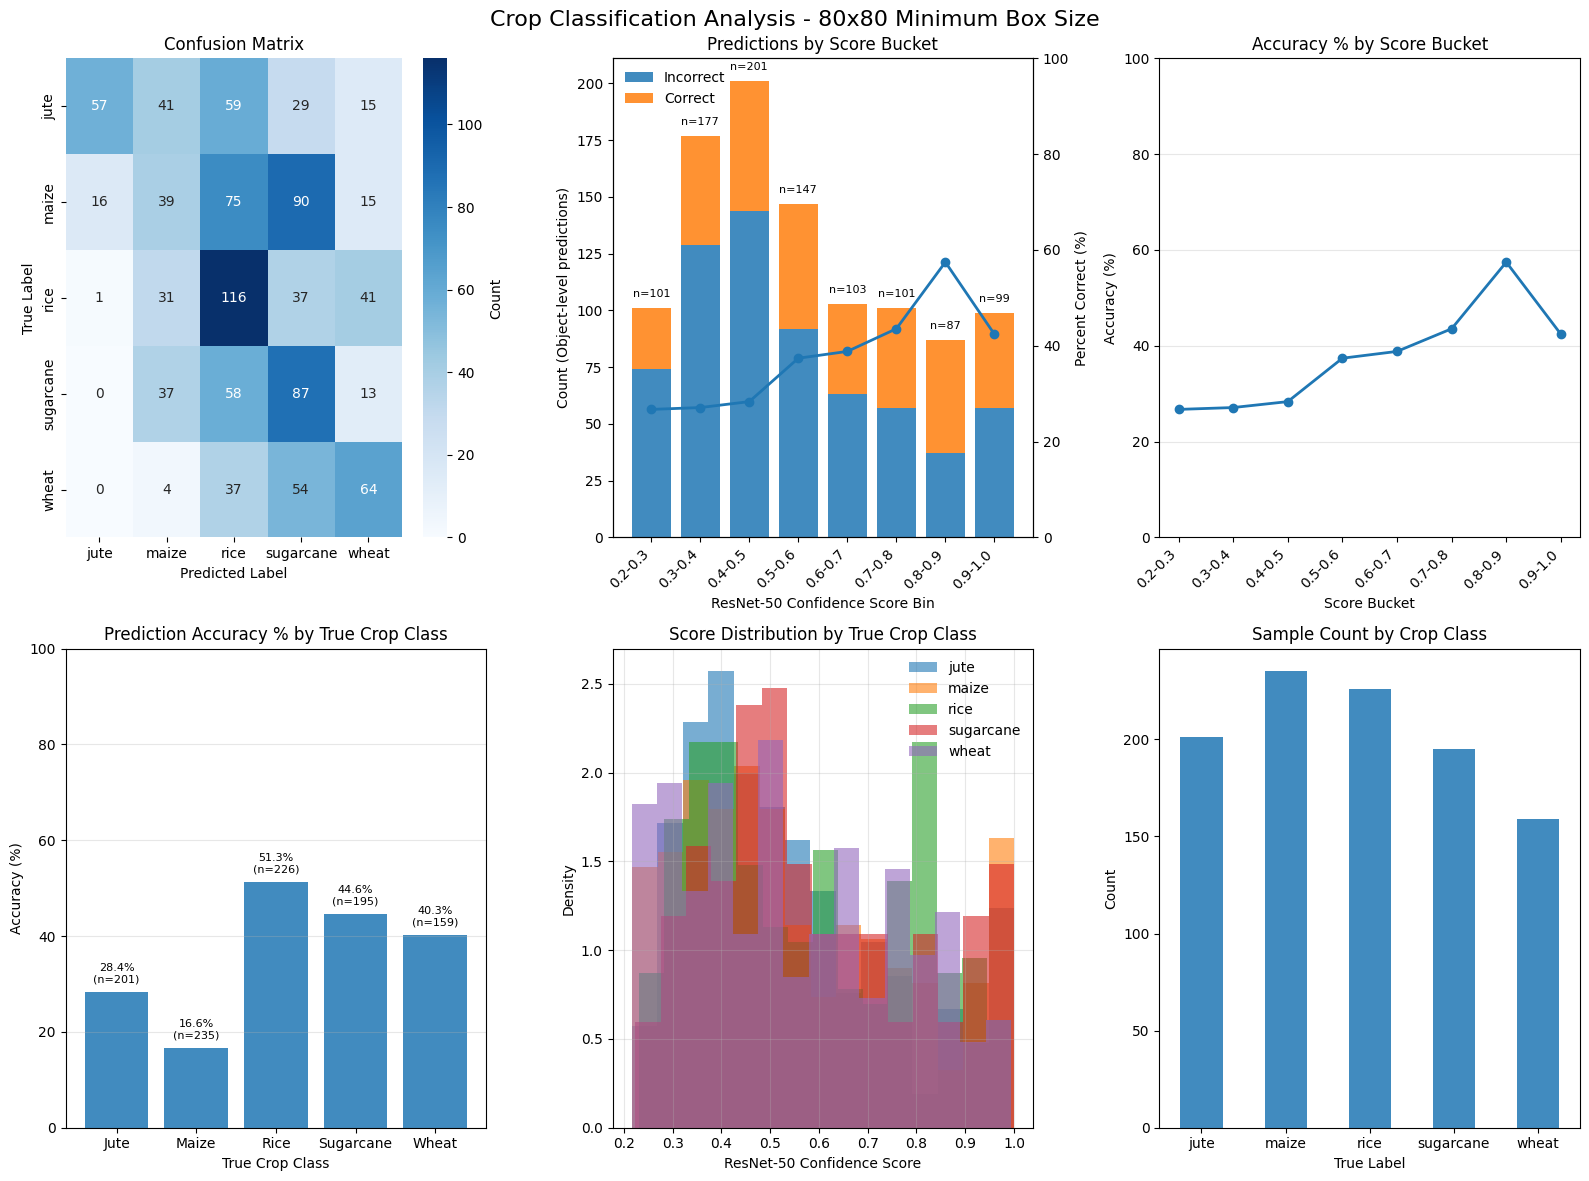


DETAILED MISCLASSIFICATION ANALYSIS

JUTE:
  Total: 201, Correct: 57, Accuracy: 28.4%
  Misclassified as:
    → rice: 59 times (29.4%)
    → maize: 41 times (20.4%)
    → sugarcane: 29 times (14.4%)
    → wheat: 15 times (7.5%)

MAIZE:
  Total: 235, Correct: 39, Accuracy: 16.6%
  Misclassified as:
    → sugarcane: 90 times (38.3%)
    → rice: 75 times (31.9%)
    → jute: 16 times (6.8%)
    → wheat: 15 times (6.4%)

RICE:
  Total: 226, Correct: 116, Accuracy: 51.3%
  Misclassified as:
    → wheat: 41 times (18.1%)
    → sugarcane: 37 times (16.4%)
    → maize: 31 times (13.7%)
    → jute: 1 times (0.4%)

SUGARCANE:
  Total: 195, Correct: 87, Accuracy: 44.6%
  Misclassified as:
    → rice: 58 times (29.7%)
    → maize: 37 times (19.0%)
    → wheat: 13 times (6.7%)

WHEAT:
  Total: 159, Correct: 64, Accuracy: 40.3%
  Misclassified as:
    → sugarcane: 54 times (34.0%)
    → rice: 37 times (23.3%)
    → maize: 4 times (2.5%)

VERIFICATION: High-confidence predictions
Score >= 0.9: 42/99 

In [ ]:
# STEP 5: CLASSIFICATION ACCURACY ANALYSIS FOR ***AERIAL*** PREDICTIONS

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def analyze_crop_classification_performance(file_path, use_strict_size_filters=True):
    """
    Analyzes crop classification performance with comprehensive metrics and visualizations.

    Args:
        file_path (str): Path to the CSV file with predictions
        use_strict_size_filters (bool): If True, uses stricter filters (80x80 boxes, score>=0.0)
                               If False, uses lenient filters (20x20 boxes, score>=0.0)
    """
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' was not found.")
        return

    try:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Check required columns
        required_columns = ['predicted_label', 'true_label', 'cropmodel_score', 'xmin', 'ymin', 'xmax', 'ymax']
        if not all(col in df.columns for col in required_columns):
            missing_cols = [col for col in required_columns if col not in df.columns]
            print(f"Error: Missing columns: {', '.join(missing_cols)}")
            return

        # Remove unknown labels - focus on 5 crop classes
        valid_labels = ['jute', 'maize', 'rice', 'sugarcane', 'wheat']
        df = df[df['true_label'].isin(valid_labels)].copy()

        print(f"Total predictions (5 crop classes): {len(df)}")
        print("Crop classes: jute (0), maize (1), rice (2), sugarcane (3), wheat (4)")

        # Apply filters based on choice
        if use_strict_size_filters:
            # Old script filters (stricter)
            MIN_CROPMODEL_SCORE = 0.0
            MIN_BOX_WIDTH = 80
            MIN_BOX_HEIGHT = 80
            MIN_BOX_AREA = 6400
            filter_description = "80x80 Minimum Box Size"
        else:
            # New script filters (more lenient)
            MIN_CROPMODEL_SCORE = 0.0
            MIN_BOX_WIDTH = 20
            MIN_BOX_HEIGHT = 20
            MIN_BOX_AREA = 400
            filter_description = "20x20 Minimum Box Size"

        print(f"\nApplying {filter_description}:")
        print(f"  Score >= {MIN_CROPMODEL_SCORE}")
        print(f"  Box size >= {MIN_BOX_WIDTH}x{MIN_BOX_HEIGHT} (area >= {MIN_BOX_AREA})")

        # Calculate box dimensions
        df['box_width'] = df['xmax'] - df['xmin']
        df['box_height'] = df['ymax'] - df['ymin']
        df['box_area'] = df['box_width'] * df['box_height']

        # Apply filters
        df_filtered = df[
            (df['cropmodel_score'] >= MIN_CROPMODEL_SCORE) &
            (df['box_width'] >= MIN_BOX_WIDTH) &
            (df['box_height'] >= MIN_BOX_HEIGHT) &
            (df['box_area'] >= MIN_BOX_AREA)
        ].copy()

        print(f"Predictions after filtering: {len(df_filtered)}")

        if df_filtered.empty:
            print("No predictions match the filter criteria!")
            return

        # Calculate correctness
        df_filtered['is_correct'] = (df_filtered['predicted_label'] == df_filtered['true_label'])
        overall_accuracy = df_filtered['is_correct'].mean() * 100
        print(f"Overall accuracy: {overall_accuracy:.2f}%")

        # --- SCORE BUCKET ANALYSIS ---
        # IMPORTANT: drop empty 0.0–0.2 buckets since they are all zero in current outputs
        bins = np.arange(0.2, 1.01, 0.1)  # 0.2–1.0
        labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-1)]
        df_filtered['score_bucket'] = pd.cut(
            df_filtered['cropmodel_score'],
            bins=bins,
            labels=labels,
            right=False,
            include_lowest=True
        )

        # Build bucket table: counts of correct/incorrect + percent correct
        bucket_counts = (
            df_filtered.groupby(['score_bucket', 'is_correct'])
            .size()
            .unstack(fill_value=0)
            .rename(columns={False: 'Incorrect_Predictions', True: 'Correct_Predictions'})
        )

        # Ensure both columns exist even if one is missing
        for col in ['Correct_Predictions', 'Incorrect_Predictions']:
            if col not in bucket_counts.columns:
                bucket_counts[col] = 0

        bucket_counts['Total_Predictions'] = bucket_counts['Correct_Predictions'] + bucket_counts['Incorrect_Predictions']
        bucket_counts['Percent_Correct'] = np.where(
            bucket_counts['Total_Predictions'] > 0,
            100 * bucket_counts['Correct_Predictions'] / bucket_counts['Total_Predictions'],
            np.nan
        )

        print(f"\n{'='*60}")
        print("ACCURACY BY SCORE BUCKET (Overall)")
        print(f"{'='*60}")
        display_cols = ['Incorrect_Predictions', 'Correct_Predictions', 'Total_Predictions', 'Percent_Correct']
        print(bucket_counts[display_cols].round(2))

        # --- CLASS-SPECIFIC ANALYSIS ---
        print(f"\n{'='*60}")
        print("ACCURACY BY CROP CLASS")
        print(f"{'='*60}")
        print("Note: This shows how well each TRUE crop class was classified")
        print("(i.e., when the actual crop was X, how often was it correctly predicted as X)")

        class_accuracy = df_filtered.groupby('true_label')['is_correct'].agg(['count', 'sum', 'mean'])
        class_accuracy.columns = ['Total_Predictions', 'Correct_Predictions', 'Accuracy_Rate']
        class_accuracy['Incorrect_Predictions'] = class_accuracy['Total_Predictions'] - class_accuracy['Correct_Predictions']
        class_accuracy['Percent_Correct'] = (class_accuracy['Accuracy_Rate'] * 100).round(1)
        class_accuracy = class_accuracy[['Total_Predictions', 'Correct_Predictions', 'Incorrect_Predictions', 'Percent_Correct']]

        # Force a consistent class order for plotting + readability
        class_order = ['jute', 'maize', 'rice', 'sugarcane', 'wheat']
        class_accuracy = class_accuracy.reindex(class_order)

        print(class_accuracy)

        # --- CONFUSION MATRIX ---
        print(f"\n{'='*60}")
        print("CONFUSION MATRIX")
        print(f"{'='*60}")
        print("Rows = True Label, Columns = Predicted Label")
        confusion_matrix = pd.crosstab(df_filtered['true_label'], df_filtered['predicted_label'], margins=True)
        print(confusion_matrix)

        # --- VISUALIZATIONS ---
        # We’ll keep 2×3 layout, but make the two *submitted* plots clearer:
        # (2) Predictions by Score Bucket -> stacked counts + accuracy line + n labels
        # (4) Prediction Accuracy % by True Crop Class -> explicit labels + % + n
        plt.figure(figsize=(16, 12))

        # 1. Confusion Matrix Heatmap
        plt.subplot(2, 3, 1)
        confusion_no_margins = pd.crosstab(df_filtered['true_label'], df_filtered['predicted_label'])
        sns.heatmap(confusion_no_margins, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.title('Confusion Matrix', fontsize=12)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        # 2. UPDATED: Predictions by Score Bucket (STACKED) + Accuracy line (2nd axis) + n labels
        ax = plt.subplot(2, 3, 2)

        x = np.arange(len(bucket_counts.index))
        incorrect = bucket_counts['Incorrect_Predictions'].values
        correct = bucket_counts['Correct_Predictions'].values
        total = bucket_counts['Total_Predictions'].values
        pct = bucket_counts['Percent_Correct'].values

        # Stacked bars (counts)
        ax.bar(x, incorrect, label='Incorrect', alpha=0.85)
        ax.bar(x, correct, bottom=incorrect, label='Correct', alpha=0.85)

        ax.set_title('Predictions by Score Bucket', fontsize=12)
        ax.set_xlabel('ResNet-50 Confidence Score Bin')
        ax.set_ylabel('Count (Object-level predictions)')
        ax.set_xticks(x)
        ax.set_xticklabels(bucket_counts.index.astype(str), rotation=45, ha='right')

        # n labels on each bar
        y_max = max(total) if len(total) else 1
        for i, t in enumerate(total):
            ax.text(i, t + 0.02 * y_max, f"n={int(t)}", ha='center', va='bottom', fontsize=8)

        # Accuracy line on secondary axis
        ax2 = ax.twinx()
        ax2.plot(x, pct, marker='o', linewidth=2)
        ax2.set_ylabel('Percent Correct (%)')
        ax2.set_ylim(0, 100)

        # Legend (explicit)
        ax.legend(loc='upper left', frameon=False)

        # 3. (Optional) keep original accuracy-by-bucket plot OR repurpose it
        plt.subplot(2, 3, 3)
        plt.plot(bucket_counts.index.astype(str), bucket_counts['Percent_Correct'].values, marker='o', linewidth=2)
        plt.title('Accuracy % by Score Bucket', fontsize=12)
        plt.xlabel('Score Bucket')
        plt.ylabel('Accuracy (%)')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 100)
        plt.grid(axis='y', alpha=0.3)

        # 4. UPDATED: Prediction Accuracy % by True Crop Class (explicit labels + % + n)
        axc = plt.subplot(2, 3, 4)
        acc_vals = class_accuracy['Percent_Correct'].values
        axc.bar(np.arange(len(class_order)), acc_vals, alpha=0.85)
        axc.set_title('Prediction Accuracy % by True Crop Class', fontsize=12)
        axc.set_xlabel('True Crop Class')
        axc.set_ylabel('Accuracy (%)')
        axc.set_ylim(0, 100)
        axc.set_xticks(np.arange(len(class_order)))
        axc.set_xticklabels([c.capitalize() for c in class_order], rotation=0)
        axc.grid(axis='y', alpha=0.3)

        # Label each bar with % and n
        ns = class_accuracy['Total_Predictions'].values
        for i, (a, n_i) in enumerate(zip(acc_vals, ns)):
            if pd.notna(a):
                axc.text(i, a + 1.5, f"{a:.1f}%\n(n={int(n_i)})", ha='center', va='bottom', fontsize=8)

        # 5. Score Distribution by Crop Class (keep as-is, but ensure consistent order/colors)
        plt.subplot(2, 3, 5)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        for i, label in enumerate(class_order):
            label_scores = df_filtered[df_filtered['true_label'] == label]['cropmodel_score']
            if len(label_scores) > 0:
                plt.hist(label_scores, bins=15, alpha=0.6, label=f'{label}',
                         color=colors[i], density=True)
        plt.xlabel('ResNet-50 Confidence Score')
        plt.ylabel('Density')
        plt.title('Score Distribution by True Crop Class')
        plt.legend(frameon=False)
        plt.grid(alpha=0.3)

        # 6. Sample Count by Class (explicit order)
        plt.subplot(2, 3, 6)
        class_counts = df_filtered['true_label'].value_counts().reindex(class_order)
        class_counts.plot(kind='bar', alpha=0.85)
        plt.title('Sample Count by Crop Class', fontsize=12)
        plt.xlabel('True Label')
        plt.ylabel('Count')
        plt.xticks(rotation=0)

        plt.suptitle(f'Crop Classification Analysis - {filter_description}', fontsize=16)
        plt.tight_layout()
        plt.show()

        # --- DETAILED CLASS PERFORMANCE ---
        print(f"\n{'='*60}")
        print("DETAILED MISCLASSIFICATION ANALYSIS")
        print(f"{'='*60}")

        for label in class_order:
            label_df = df_filtered[df_filtered['true_label'] == label]
            if not label_df.empty:
                accuracy = label_df['is_correct'].mean() * 100
                total_lab = len(label_df)
                correct_lab = label_df['is_correct'].sum()

                print(f"\n{label.upper()}:")
                print(f"  Total: {total_lab}, Correct: {correct_lab}, Accuracy: {accuracy:.1f}%")

                misclassified = label_df[label_df['is_correct'] == False]
                if len(misclassified) > 0:
                    misclass_counts = misclassified['predicted_label'].value_counts()
                    print(f"  Misclassified as:")
                    for pred_label, count in misclass_counts.items():
                        pct_mis = (count / total_lab) * 100
                        print(f"    → {pred_label}: {count} times ({pct_mis:.1f}%)")

        # --- VERIFICATION: High confidence predictions
        print(f"\n{'='*60}")
        print("VERIFICATION: High-confidence predictions")
        print(f"{'='*60}")

        high_conf = df_filtered[df_filtered['cropmodel_score'] >= 0.9]
        if len(high_conf) > 0:
            high_conf_accuracy = high_conf['is_correct'].mean() * 100
            print(f"Score >= 0.9: {high_conf['is_correct'].sum()}/{len(high_conf)} = {high_conf_accuracy:.1f}% accuracy")

        bucket_09 = df_filtered[(df_filtered['cropmodel_score'] >= 0.9) & (df_filtered['cropmodel_score'] < 1.0)]
        if len(bucket_09) > 0:
            bucket_09_acc = bucket_09['is_correct'].mean() * 100
            print(f"Score 0.9-1.0 bin: {bucket_09['is_correct'].sum()}/{len(bucket_09)} = {bucket_09_acc:.1f}% accuracy")

    except Exception as e:
        print(f"Error occurred: {e}")

def compare_filter_effects(file_path):
    print("COMPARING FILTER EFFECTS")
    print("="*50)

    print("1. APPLIED FILTERS (Stricter - matches previous results):")
    analyze_crop_classification_performance(file_path, use_strict_size_filters=True)

    print("\n" + "="*50)
    print("2. SENSITIVE FILTERS (More Lenient):")
    analyze_crop_classification_performance(file_path, use_strict_size_filters=False)

if __name__ == "__main__":
    file_path = "pred_output_tiles_aerial_with_true_label.csv"
    analyze_crop_classification_performance(file_path, use_strict_size_filters=True)
    # compare_filter_effects(file_path)


CANOPY COMPLEXITY AND DRONE-BASED CROP CLASSIFICATION
A Biological Approach to Understanding AI Model Performance
CANOPY COMPLEXITY AND MULTI-PERSPECTIVE IMAGERY ANALYSIS

MULTI-PERSPECTIVE Dataset:
  Total filtered predictions: 665
  Jute: 80/151 = 53.0%
  Wheat: 71/144 = 49.3%
  Maize: 45/143 = 31.5%
  Sugarcane: 91/110 = 82.7%
  Rice: 65/117 = 55.6%

AERIAL-ONLY Dataset:
  Total filtered predictions: 1016
  Jute: 57/201 = 28.4%
  Wheat: 64/159 = 40.3%
  Maize: 39/235 = 16.6%
  Sugarcane: 87/195 = 44.6%
  Rice: 116/226 = 51.3%

COMPARISON ANALYSIS
        crop  complexity_score  multi_perspective_accuracy  \
0       jute                 3                        53.0   
1      wheat                 1                        49.3   
2      maize                 2                        31.5   
3  sugarcane                 3                        82.7   
4       rice                 1                        55.6   

   aerial_only_accuracy  accuracy_improvement  multi_total  aerial_tota

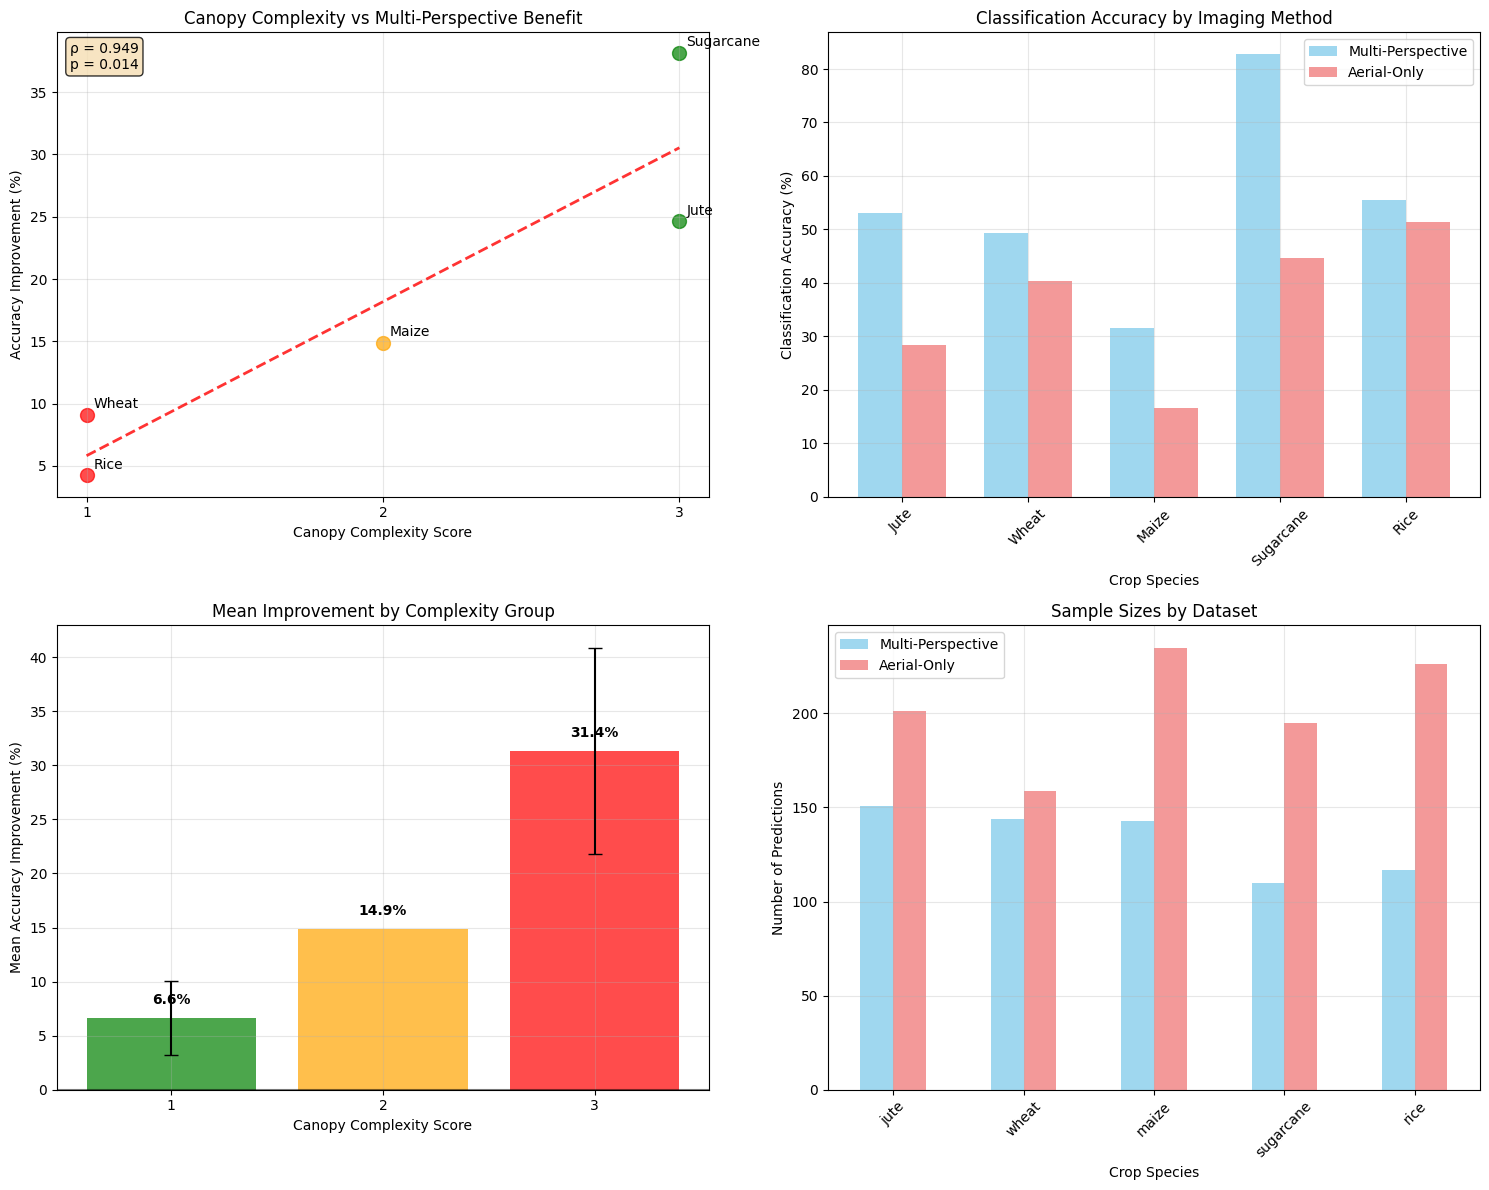


BIOLOGICAL AND AI INSIGHTS

1. CANOPY COMPLEXITY EFFECT:
   ✓ Statistically significant positive correlation supports hypothesis
   → Complex canopies benefit more from multi-perspective imagery
   → 3D structural features are key visual cues for AI classification

2. MORPHOLOGICAL INSIGHTS:
   • High complexity crops (sugarcane): 31.4% avg improvement
   • Medium complexity crops (maize, jute): 14.9% avg improvement
   • Low complexity crop (rice, wheat): 9.1% improvement

3. RICE PARADOX:

4. AI MODEL IMPLICATIONS:
   • Structural heterogeneity requires multiple viewing angles
   • 3D canopy architecture affects classification performance
   • Morphological distinctiveness matters for machine learning
   • Uniform crops may not benefit from complex imaging approaches

   Results saved to: /content/canopy_analysis_results.csv
Reading computed results from: /content/canopy_analysis_results.csv

CANOPY COMPLEXITY SCORING TABLE
     Crop  Complexity_Score                                

In [ ]:
# STEP 6: ANALYZE CANOPY COMPLEXITY IMPACT

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, f_oneway
import warnings
warnings.filterwarnings('ignore')

def analyze_canopy_complexity_hypothesis(multi_file, aerial_file, save_results_path='/content/canopy_analysis_results.csv'):
    """
    Statistical analysis of the relationship between canopy complexity
    and multi-perspective imagery effectiveness for crop classification.

     Args:
      multi_file: Path to multi-perspective CSV
      aerial_file: Path to aerial-only CSV
      save_results_path: Path to save computed results (default: /content/ for Colab)
    """

    print("="*70)
    print("CANOPY COMPLEXITY AND MULTI-PERSPECTIVE IMAGERY ANALYSIS")
    print("="*70)

    # Define canopy complexity scoring based on drone-observable traits
    # Scoring reflects what is visible from aerial/oblique drone views
    complexity_scores = {
      'sugarcane': 3, # High complexity - tall vertical structure (3-6m), viewing angle differences
      'jute': 3,      # High complexity - branching visible from multiple angles
      'maize': 2,     # Medium complexity - large leaves, tassel/ear visible from sides
      'wheat': 1,     # Low complexity - uniform grass-like appearance from drone
      'rice': 1       # Low complexity - erect ideotype, uniform from above
    }

    valid_labels = ['jute', 'wheat', 'maize', 'sugarcane', 'rice']

    def process_dataset(file_path, dataset_name):
        """Process dataset and calculate classification accuracy by crop."""
        df = pd.read_csv(file_path)

        # Remove unknown labels and focus on 5 crop classes
        df = df[df['true_label'].isin(valid_labels)].copy()

        # Calculate box dimensions
        df['box_width'] = df['xmax'] - df['xmin']
        df['box_height'] = df['ymax'] - df['ymin']
        df['box_area'] = df['box_width'] * df['box_height']

        # Apply strict filters (matching old script for consistency)
        df_filtered = df[
            (df['cropmodel_score'] >= 0.0) &
            (df['box_width'] >= 80) &
            (df['box_height'] >= 80) &
            (df['box_area'] >= 6400)
        ].copy()

        print(f"\n{dataset_name} Dataset:")
        print(f"  Total filtered predictions: {len(df_filtered)}")

        # Calculate accuracy by crop
        df_filtered['is_correct'] = (df_filtered['predicted_label'] == df_filtered['true_label'])

        accuracy_results = {}
        for crop in valid_labels:
            crop_data = df_filtered[df_filtered['true_label'] == crop]
            if len(crop_data) > 0:
                accuracy = crop_data['is_correct'].mean() * 100
                total = len(crop_data)
                correct = crop_data['is_correct'].sum()
                accuracy_results[crop] = {
                    'total': total,
                    'correct': correct,
                    'accuracy': accuracy
                }
                print(f"  {crop.capitalize()}: {correct}/{total} = {accuracy:.1f}%")

        return accuracy_results

    # Process both datasets
    multi_results = process_dataset(multi_file, "MULTI-PERSPECTIVE")
    aerial_results = process_dataset(aerial_file, "AERIAL-ONLY")

    # Create comparison dataframe
    comparison_data = []
    for crop in valid_labels:
        if crop in multi_results and crop in aerial_results:
            multi_acc = multi_results[crop]['accuracy']
            aerial_acc = aerial_results[crop]['accuracy']
            improvement = multi_acc - aerial_acc
            complexity = complexity_scores[crop]

            comparison_data.append({
                'crop': crop,
                'complexity_score': complexity,
                'multi_perspective_accuracy': multi_acc,
                'aerial_only_accuracy': aerial_acc,
                'accuracy_improvement': improvement,
                'multi_total': multi_results[crop]['total'],
                'aerial_total': aerial_results[crop]['total']
            })

    df_comparison = pd.DataFrame(comparison_data)

    print(f"\n{'='*70}")
    print("COMPARISON ANALYSIS")
    print(f"{'='*70}")
    print(df_comparison.round(1))

    # Statistical Analysis
    print(f"\n{'='*70}")
    print("STATISTICAL HYPOTHESIS TESTING")
    print(f"{'='*70}")

    # Spearman's Rank Correlation
    complexity_values = df_comparison['complexity_score'].values
    improvement_values = df_comparison['accuracy_improvement'].values

    spearman_corr, spearman_p = spearmanr(complexity_values, improvement_values)

    print(f"\n1. SPEARMAN'S RANK CORRELATION")
    print(f"   Research Question: Is there a monotonic relationship between canopy")
    print(f"   complexity and the benefit of multi-perspective imagery?")
    print(f"   ")
    print(f"   H₀: No correlation between complexity and accuracy improvement (ρ = 0)")
    print(f"   H₁: Positive correlation exists (ρ > 0)")
    print(f"   ")
    print(f"   Spearman's ρ = {spearman_corr:.3f}")
    print(f"   p-value = {spearman_p:.3f}")
    print(f"   Significance level: α = 0.05")

    if spearman_p < 0.05:
        if spearman_corr > 0:
            print(f"   ✓ SIGNIFICANT POSITIVE CORRELATION (p < 0.05)")
            print(f"   → Higher complexity correlates with greater multi-perspective benefit")
        else:
            print(f"   ✓ SIGNIFICANT NEGATIVE CORRELATION (p < 0.05)")
            print(f"   → Higher complexity correlates with lower multi-perspective benefit")
    else:
        print(f"   ✗ NO SIGNIFICANT CORRELATION (p ≥ 0.05)")

    # Group by complexity for ANOVA
    complexity_groups = df_comparison.groupby('complexity_score')['accuracy_improvement'].apply(list).to_dict()

    print(f"\n2. ONE-WAY ANOVA")
    print(f"   Research Question: Do different complexity groups have significantly")
    print(f"   different mean accuracy improvements?")
    print(f"   ")
    print(f"   H₀: All group means are equal")
    print(f"   H₁: At least one group mean differs significantly")
    print(f"   ")

    # Calculate group statistics
    for score, improvements in complexity_groups.items():
        mean_improvement = np.mean(improvements)
        crops_in_group = df_comparison[df_comparison['complexity_score'] == score]['crop'].tolist()
        print(f"   Complexity {score}: Mean = {mean_improvement:.1f}% (crops: {', '.join(crops_in_group)})")

    # Perform ANOVA (note: small sample size limitation)
    if len(complexity_groups) >= 2:
        group_values = list(complexity_groups.values())

        # Check if we have enough data points for ANOVA
        total_points = sum(len(group) for group in group_values)
        if total_points >= 3:  # Need at least 3 data points total
            f_stat, anova_p = f_oneway(*group_values)

            print(f"   ")
            print(f"   F-statistic = {f_stat:.3f}")
            print(f"   p-value = {anova_p:.3f}")

            if anova_p < 0.05:
                print(f"   ✓ SIGNIFICANT GROUP DIFFERENCES (p < 0.05)")
                print(f"   → Complexity level significantly affects accuracy improvement")
            else:
                print(f"   ✗ NO SIGNIFICANT GROUP DIFFERENCES (p ≥ 0.05)")
        else:
            print(f"   Note: Insufficient data points for ANOVA (n={total_points})")
            print(f"   → Each complexity group has only 1-2 crops")
            print(f"   → Consider descriptive analysis instead")
    else:
        print(f"   Note: Insufficient groups for ANOVA analysis")

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Complexity vs Improvement Scatter Plot
    ax1 = axes[0, 0]
    colors = ['red', 'orange', 'green']
    for i, crop in enumerate(df_comparison['crop']):
        complexity = df_comparison.loc[i, 'complexity_score']
        improvement = df_comparison.loc[i, 'accuracy_improvement']
        ax1.scatter(complexity, improvement, c=colors[complexity-1], s=100, alpha=0.7)
        ax1.annotate(crop.capitalize(), (complexity, improvement),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)

    ax1.set_xlabel('Canopy Complexity Score')
    ax1.set_ylabel('Accuracy Improvement (%)')
    ax1.set_title('Canopy Complexity vs Multi-Perspective Benefit')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks([1, 2, 3])

    # Add trend line
    z = np.polyfit(complexity_values, improvement_values, 1)
    p = np.poly1d(z)
    ax1.plot([1, 2, 3], p([1, 2, 3]), "r--", alpha=0.8, linewidth=2)
    ax1.text(0.02, 0.98, f'ρ = {spearman_corr:.3f}\np = {spearman_p:.3f}',
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # 2. Accuracy Comparison by Crop
    ax2 = axes[0, 1]
    x = np.arange(len(valid_labels))
    width = 0.35

    multi_accs = [df_comparison[df_comparison['crop']==crop]['multi_perspective_accuracy'].iloc[0]
                  for crop in valid_labels]
    aerial_accs = [df_comparison[df_comparison['crop']==crop]['aerial_only_accuracy'].iloc[0]
                   for crop in valid_labels]

    ax2.bar(x - width/2, multi_accs, width, label='Multi-Perspective', color='skyblue', alpha=0.8)
    ax2.bar(x + width/2, aerial_accs, width, label='Aerial-Only', color='lightcoral', alpha=0.8)

    ax2.set_xlabel('Crop Species')
    ax2.set_ylabel('Classification Accuracy (%)')
    ax2.set_title('Classification Accuracy by Imaging Method')
    ax2.set_xticks(x)
    ax2.set_xticklabels([crop.capitalize() for crop in valid_labels], rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Improvement by Complexity Group
    ax3 = axes[1, 0]
    complexity_means = df_comparison.groupby('complexity_score')['accuracy_improvement'].mean()
    complexity_std = df_comparison.groupby('complexity_score')['accuracy_improvement'].std()

    bars = ax3.bar(complexity_means.index, complexity_means.values,
                   yerr=complexity_std.values, capsize=5, color=['green', 'orange', 'red'], alpha=0.7)
    ax3.set_xlabel('Canopy Complexity Score')
    ax3.set_ylabel('Mean Accuracy Improvement (%)')
    ax3.set_title('Mean Improvement by Complexity Group')
    ax3.set_xticks([1, 2, 3])
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Add value labels on bars
    for bar, value in zip(bars, complexity_means.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 4. Sample Size Information
    ax4 = axes[1, 1]
    sample_sizes = df_comparison[['crop', 'multi_total', 'aerial_total']].set_index('crop')
    sample_sizes.plot(kind='bar', ax=ax4, color=['skyblue', 'lightcoral'], alpha=0.8)
    ax4.set_xlabel('Crop Species')
    ax4.set_ylabel('Number of Predictions')
    ax4.set_title('Sample Sizes by Dataset')
    ax4.legend(['Multi-Perspective', 'Aerial-Only'])
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Generate conclusions
    print(f"\n{'='*70}")
    print("BIOLOGICAL AND AI INSIGHTS")
    print(f"{'='*70}")

    print(f"\n1. CANOPY COMPLEXITY EFFECT:")
    if spearman_p < 0.05 and spearman_corr > 0:
        print(f"   ✓ Statistically significant positive correlation supports hypothesis")
        print(f"   → Complex canopies benefit more from multi-perspective imagery")
        print(f"   → 3D structural features are key visual cues for AI classification")
    elif spearman_p < 0.05 and spearman_corr < 0:
        print(f"   ! Significant NEGATIVE correlation found (unexpected)")
        print(f"   → Simple structures may benefit more from multi-perspective imagery")
        print(f"   → Complex canopies may be confusing with multiple viewpoints")
    else:
        print(f"   ✗ No significant correlation found")
        print(f"   → Complexity scoring may be too coarse")
        print(f"   → Other factors may confound the relationship")

    print(f"\n2. MORPHOLOGICAL INSIGHTS:")
    print(f"   • High complexity crops (sugarcane): {df_comparison[df_comparison['complexity_score']==3]['accuracy_improvement'].mean():.1f}% avg improvement")
    print(f"   • Medium complexity crops (maize, jute): {df_comparison[df_comparison['complexity_score']==2]['accuracy_improvement'].mean():.1f}% avg improvement")
    print(f"   • Low complexity crop (rice, wheat): {df_comparison[df_comparison['complexity_score']==1]['accuracy_improvement'].iloc[0]:.1f}% improvement")

    print(f"\n3. RICE PARADOX:")
    rice_improvement = df_comparison[df_comparison['crop']=='rice']['accuracy_improvement'].iloc[0]
    if rice_improvement < 0:
        print(f"   • Rice performs BETTER with aerial-only imagery ({rice_improvement:.1f}%)")
        print(f"   • Uniform 'ideotype' structure is more distinguishable from above")
        print(f"   • Erect leaf arrangement creates consistent aerial signature")
        print(f"   • Multiple perspectives may introduce unnecessary noise")

    print(f"\n4. AI MODEL IMPLICATIONS:")
    print(f"   • Structural heterogeneity requires multiple viewing angles")
    print(f"   • 3D canopy architecture affects classification performance")
    print(f"   • Morphological distinctiveness matters for machine learning")
    print(f"   • Uniform crops may not benefit from complex imaging approaches")

    # Save results to CSV for use by create_canopy_complexity_table()
    if save_results_path:
      df_comparison.to_csv(save_results_path, index=False)
      print(f"\n   Results saved to: {save_results_path}")

    return df_comparison, spearman_corr, spearman_p

def create_canopy_complexity_table(results_path='/content/canopy_analysis_results.csv'):
  """Create a comprehensive table of canopy complexity scoring.


  Reads computed accuracy values from the saved results file generated by
  analyze_canopy_complexity_hypothesis().

  Args:
    results_path: Path to the saved results CSV (default: /content/ for Colab)
  """

  # Static data – drone-observable canopy complexity (not botanical complexity)
  crop_info = {
      'rice': {
          'Complexity_Score': 1,
          'Key_Structural_Features': (
              'Erect growth form with uniform leaf orientation and minimal vertical layering, '
              'producing a consistent top-down appearance'
          ),
          'Scientific_Basis': (
              'Rice exhibits an erect and vertically uniform canopy, resulting in limited '
              'structural variation in aerial imagery (Peng et al., 2004; Yu et al., 2021)'
          )
      },
      'wheat': {
          'Complexity_Score': 1,
          'Key_Structural_Features': (
              'Grass-like canopy with basal tillering that is largely obscured from aerial views'
          ),
          'Scientific_Basis': (
              'Wheat tillering occurs near the plant base and contributes little to '
              'aerially visible canopy structure, leading to a relatively uniform appearance '
              'in drone imagery (Donald, 1968; Zhang et al., 2022)'
          )
      },
      'maize': {
          'Complexity_Score': 2,
          'Key_Structural_Features': (
              'Large leaves with variable angles and visible reproductive structures '
              'that become more apparent from oblique views'
          ),
          'Scientific_Basis': (
              'Maize exhibits intermediate canopy complexity due to variable leaf angles '
              'and vertically distributed organs that are better captured using multi-view '
              'UAV imagery (Maddonni et al., 2001; Ghanbari Parmehr and Amati, 2021)'
          )
      },
      'jute': {
          'Complexity_Score': 3,
          'Key_Structural_Features': (
              'Branched canopy with heterogeneous leaf shapes and multi-level vertical structure'
          ),
          'Scientific_Basis': (
              'Jute forms a branched and heterogeneous canopy in which diagnostic features '
              'vary with viewing angle, increasing structural complexity in drone imagery '
              '(Saha et al., 2008; van Leeuwen et al., 2013)'
          )
      },
      'sugarcane': {
          'Complexity_Score': 3,
          'Key_Structural_Features': (
              'Tall (3–6 m), vertically layered canopy with alternating leaves visible from oblique angles'
          ),
          'Scientific_Basis': (
              'Sugarcane’s tall and vertically layered canopy produces strong variation in '
              'visible structure across viewing angles, increasing drone-observable complexity '
              '(Goel, 1988; Singh et al., 2024)'
          )
      }
  }


  # Read computed results from saved file
  if os.path.exists(results_path):
    df_results = pd.read_csv(results_path)
    print(f"Reading computed results from: {results_path}")
  else:
    print(f"Warning: Results file not found at {results_path}")
    print("Please run analyze_canopy_complexity_hypothesis() first to generate results.")
    return None

  # Build table ordered by drone-observable complexity: Low (1) to High (3)
  table_order = ['rice', 'wheat', 'maize', 'jute', 'sugarcane']

  table_data = {
  'Crop': [],
  'Complexity_Score': [],
  'Key_Structural_Features': [],
  'Multi_Accuracy': [],
  'Aerial_Accuracy': [],
  'Improvement': [],
  'Scientific_Basis': []
  }

  for crop in table_order:
    crop_row = df_results[df_results['crop'] == crop]
    if not crop_row.empty:
      table_data['Crop'].append(crop.capitalize())
      table_data['Complexity_Score'].append(crop_info[crop]['Complexity_Score'])
      table_data['Key_Structural_Features'].append(crop_info[crop]['Key_Structural_Features'])
      table_data['Multi_Accuracy'].append(round(crop_row['multi_perspective_accuracy'].iloc[0], 1))
      table_data['Aerial_Accuracy'].append(round(crop_row['aerial_only_accuracy'].iloc[0], 1))
      table_data['Improvement'].append(round(crop_row['accuracy_improvement'].iloc[0], 1))
      table_data['Scientific_Basis'].append(crop_info[crop]['Scientific_Basis'])

    df_table = pd.DataFrame(table_data)


  print(f"\n{'='*70}")
  print("CANOPY COMPLEXITY SCORING TABLE")
  print(f"{'='*70}")
  print(df_table.to_string(index=False))

  return df_table

def generate_research_conclusions(spearman_corr, spearman_p, df_comparison):
    """Generate research conclusions based on statistical results."""

    print(f"\n{'='*70}")
    print("RESEARCH CONCLUSIONS AND IMPLICATIONS")
    print(f"{'='*70}")

    if spearman_p < 0.05:
        print(f"\n✓ HYPOTHESIS SUPPORTED (p = {spearman_p:.3f} < 0.05)")
        print(f"   Claim 1: Statistically significant correlation exists")
        print(f"   → Canopy complexity rubric is biologically meaningful and predictive")
        print(f"   → Multi-perspective imaging effectiveness varies with plant architecture")

        if spearman_corr > 0:
            print(f"   → Positive correlation: Complex canopies benefit from multiple viewpoints")
        else:
            print(f"   → Negative correlation: Simple canopies benefit more (unexpected finding)")

        print(f"\n   Claim 2: Structural traits are key visual cues for AI models")
        print(f"   → 3D morphological features affect machine learning performance")
        print(f"   → Canopy-level architecture influences classification accuracy")

    else:
        print(f"\n✗ HYPOTHESIS NOT SUPPORTED (p = {spearman_p:.3f} ≥ 0.05)")
        print(f"   Possible explanations:")
        print(f"   → Complexity scoring may be too coarse (n=5 crops)")
        print(f"   → Confounding factors: lighting, crop color, growth stage")
        print(f"   → Model limitations in leveraging structural traits")
        print(f"   → Need larger, more diverse crop dataset")

    print(f"\n{'='*70}")
    print("KEY FINDINGS FOR PUBLICATION")
    print(f"{'='*70}")

    # Sort crops by improvement for clear presentation
    sorted_crops = df_comparison.sort_values('accuracy_improvement', ascending=False)

    print(f"\n1. MULTI-PERSPECTIVE IMAGERY EFFECTIVENESS:")
    print(f"   Most benefited crops:")
    for idx, row in sorted_crops.head(2).iterrows():
        print(f"   • {row['crop'].capitalize()}: +{row['accuracy_improvement']:.1f}% improvement (Complexity: {row['complexity_score']})")

    print(f"   Least benefited crops:")
    for idx, row in sorted_crops.tail(2).iterrows():
        print(f"   • {row['crop'].capitalize()}: {row['accuracy_improvement']:.1f}% change (Complexity: {row['complexity_score']})")

    print(f"\n2. BIOLOGICAL IMPLICATIONS:")
    print(f"   • Morphological complexity affects AI observability")
    print(f"   • 3D canopy architecture is a key factor in classification")
    print(f"   • Uniform vs heterogeneous structures require different imaging approaches")

    print(f"\n3. METHODOLOGICAL CONTRIBUTIONS:")
    print(f"   • Novel framework linking plant morphology to AI performance")
    print(f"   • Biologically-grounded complexity scoring system")
    print(f"   • Multi-perspective drone imaging optimization strategy")

    print(f"\n4. LIMITATIONS AND FUTURE WORK:")
    print(f"   • Small number of crop species (n=5) limits statistical power")
    print(f"   • Complexity scoring could be refined with more morphological parameters")
    print(f"   • Larger datasets needed to strengthen morphology-AI performance links")
    print(f"   • Environmental factors (lighting, growth stage) need consideration")

if __name__ == "__main__":
    # File paths
    multi_file = "pred_output_tiles_multiperspective_with_true_label.csv"
    aerial_file = "pred_output_tiles_aerial_with_true_label.csv"
    results_path = "/content/canopy_analysis_results.csv"

    # Run complete analysis
    print("CANOPY COMPLEXITY AND DRONE-BASED CROP CLASSIFICATION")
    print("A Biological Approach to Understanding AI Model Performance")
    print("="*70)

    # STEP 1: Perform statistical analysis FIRST (this saves results to CSV)
    comparison_df, spearman_corr, spearman_p = analyze_canopy_complexity_hypothesis(
      multi_file, aerial_file, save_results_path=results_path
    )

    # STEP 2: Create complexity table using saved results
    complexity_table = create_canopy_complexity_table(results_path=results_path)

    # Generate conclusions
    generate_research_conclusions(spearman_corr, spearman_p, comparison_df)

    print(f"\n{'='*70}")
    print("ANALYSIS COMPLETE")
    print(f"{'='*70}")
    print(f"Results ready for JEI manuscript preparation.")
    print(f"Statistical framework validates biological hypothesis testing approach.")